# predicting OnMarket 

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
import datetime
from datetime import timedelta
import ast
import json    
import missingno as msno
import seaborn as sns
import arabic_reshaper
from bidi.algorithm import get_display
from sklearn.impute import SimpleImputer
# from sklearn_pandas import CategoricalImputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score, accuracy_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
# Helper packages
from plotnine import *

# Modeling packages
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from catboost import CatBoostRegressor, cv, Pool

from collections import defaultdict

from hyperopt import hp, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

import shap
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline

from tqdm import tqdm


## i will use in all the models 5 cross vaildation and MRSE to measure the ERROR 

In [23]:
loss = 'neg_root_mean_squared_error'
k = 5 #k-fold

In [24]:
df = pd.read_csv('../data/ML.csv')
df['user_id'] = df['user_id'].astype('object')

delete outliers as in the EDA

In [25]:
df =df[df['beds'] <=5]
df = df.loc[(df['review'] > 3) | (df['review'] == 1)]
df = df[df['price'] <=100*1000]
df = df[df['isRent']==True]
df = df[df['onMarket']<=75]

In [26]:
df.drop(['createYEAR'],axis=1 ,inplace=True)
df.drop(['createDAY'],axis=1 ,inplace=True)
df.drop(['createMONTH'],axis=1 ,inplace=True)
df.drop(['lUpdateDAY'],axis=1 ,inplace=True)
df.drop(['lUpdateMONTH'],axis=1 ,inplace=True)
df.drop(['lUpdateYEAR'],axis=1 ,inplace=True)
df.drop(['id'],axis=1 ,inplace=True)

In [27]:

X = df.drop(['isRent' , 'DayOfRent' , 'timeBeforeRent'  , 'onMarket'  ] , axis=1)
y = df['onMarket']

In [28]:
X.columns

Index(['user_id', 'len_of_title', 'price', 'len_of_content', 'img_in_posd',
       'beds', 'livings', 'wc', 'area', 'street_width', 'age', 'ketchen', 'ac',
       'furnished', 'district', 'advertiser_type', 'review', 'profileImg',
       'iam_verified', 'zone'],
      dtype='object')

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
train_df = X_train.join(y_train)
test_df =X_test.join(y_test)

low varince

In [30]:
nzv = VarianceThreshold(threshold=0.1)

dealing with Skewness

In [31]:
yj = PowerTransformer(method="yeo-johnson")
# X_norm = ColumnTransformer([("norm", yj, selector(dtype_include="number"))])

Standardization

In [32]:
scaler = StandardScaler()

# standardize all numeric features
# std = ColumnTransformer([("norm", scaler, selector(dtype_include="number"))])

OneHotEncoder for advertiser_type

In [33]:
encoder = OneHotEncoder(handle_unknown="ignore")


rediction the dim

In [34]:
# pca = PCA(n_components=11)


In [35]:
preprocessor = ColumnTransformer(
  remainder="passthrough",
  transformers=[
  ("nzv_encode", nzv, selector(dtype_include="number")),
  ("norm", yj, selector(dtype_include="number")),
  ("std_encode", scaler, selector(dtype_include="number")),
  # ("pca_encode", pca, selector(dtype_include="number")),
  ("one-hot", encoder, selector(dtype_include="object")),
  ])

In [36]:
from sklearn.linear_model import RidgeCV
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence

# RidgeCV

In [37]:
alphas = [1,10 , 20]
reg = RidgeCV(alphas= alphas , store_cv_values=True)

model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("reg", reg),
])
cb_reg_1 = model_pipeline.fit(X_train , y_train)
cv_MSE = np.mean(reg.cv_values_, axis=0)

In [38]:
alphas

[1, 10, 20]

In [39]:
cv_MSE

array([247.45161418, 255.3278743 , 264.78424865])

In [40]:
reg.alpha_

1

In [41]:
results =cross_val_score(cb_reg_1, X_test, y_test.values.ravel(), cv=k, scoring=loss)
np.abs(np.mean(results))

16.7650238503141

# catBoost


In [42]:

cb_reg_1 = CatBoostRegressor( random_seed=13, verbose=200)

pipeline  = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("cb_reg_1", cb_reg_1),
])
pipeline.fit(X_train , y_train)
# scores = cross_val_score(model_pipeline, X_train, y_train, cv = 5 )
# scores = GridSearchCV(model_pipeline, X_train, y_train , cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
results = cross_val_score(model_pipeline, X_test, y_test.values.ravel(), cv=k, scoring=loss)


Learning rate set to 0.046011
0:	learn: 17.7263149	total: 52.7ms	remaining: 52.6s
200:	learn: 14.4428067	total: 468ms	remaining: 1.86s
400:	learn: 13.0261412	total: 880ms	remaining: 1.31s
600:	learn: 12.0007842	total: 1.28s	remaining: 848ms
800:	learn: 11.2396419	total: 1.65s	remaining: 410ms
999:	learn: 10.5479946	total: 2.06s	remaining: 0us


In [43]:

np.abs(np.mean(results))

16.7650238503141

-----------

In [44]:
class DataProcessor(object):
    def __init__(self):
        self.encoder = None
        self.standard_scaler = None
        self.num_cols = None
        self.cat_cols = None
        
    def preprocess(self, data_df, train=True, one_hot_encode=False,
                   combine_min_cats=False, add_pca_feats=False):
        """ Preprocess train / test as required """
        
        # if training, fit our transformers
        if train:
            self.train_ids = data_df.loc[:, 'id']
            train_cats = data_df.loc[:, data_df.dtypes == object]
            self.cat_cols = train_cats.columns
            
            # if selected, combine minority categorical feats
            if combine_min_cats:
                self._find_minority_cats(train_cats)
                train_cats = self._combine_minority_feats(train_cats)
            
            # if selected, one hot encode our cat features
            if one_hot_encode:
                self.encoder = OneHotEncoder(handle_unknown='ignore')
                oh_enc = self.encoder.fit_transform(train_cats).toarray()
                train_cats_enc = pd.DataFrame(oh_enc, columns=self.encoder.get_feature_names(), 
                                              dtype=np.int64)
                self.final_cat_cols = list(train_cats_enc.columns)
            
            # otherwise just encode our cat feats with ints
            else:
                # encode all of our categorical variables
                self.encoder = defaultdict(LabelEncoder)
                train_cats_enc = train_cats.apply(lambda x: 
                                                  self.encoder[x.name].fit_transform(x))
                self.final_cat_cols = list(self.cat_cols)
            
            
            # standardise all numerical columns
            train_num = data_df.loc[:, data_df.dtypes != object].drop(columns=['onMarket', 'id'])
            self.num_cols = train_num.columns
            self.standard_scaler = StandardScaler()
            train_num_std = self.standard_scaler.fit_transform(train_num)
            
            # add pca reduced num feats if selected, else just combine num + cat feats
            if add_pca_feats:
                pca_feats = self._return_num_pca(train_num_std)
                self.final_num_feats = list(self.num_cols)+list(self.pca_cols)
                
                
                X = pd.DataFrame(np.hstack((train_cats_enc, train_num_std, pca_feats)), 
                        columns=list(self.final_cat_cols)+list(self.num_cols)+list(self.pca_cols))
            else:   
                self.final_num_feats = list(self.num_cols)
                X = pd.DataFrame(np.hstack((train_cats_enc, train_num_std)), 
                        columns=list(self.final_cat_cols)+list(self.num_cols))
        
        # otherwise, treat as test data
        else:
            # transform categorical and numerical data
            # self.test_ids = data_df.loc[:, 'id']
            cat_data = data_df.loc[:, self.cat_cols]
            if combine_min_cats:
                cat_data = self._combine_minority_feats(cat_data)
        
            if one_hot_encode:
                oh_enc = self.encoder.transform(cat_data).toarray()
                cats_enc = pd.DataFrame(oh_enc, 
                                        columns=self.encoder.get_feature_names(), 
                                        dtype=np.int64)
            else:
                cats_enc = cat_data.apply(lambda x: self.encoder[x.name].transform(x))
                
            # transform test numerical data
            num_data = data_df.loc[:, self.num_cols]
            num_std = self.standard_scaler.transform(num_data)
            
            if add_pca_feats:
                pca_feats = self._return_num_pca(num_std, train=False)
                
                X = pd.DataFrame(np.hstack((cats_enc, num_std, pca_feats)), 
                        columns=list(self.final_cat_cols)+list(self.num_cols)+list(self.pca_cols))
            
            else:
                X = pd.DataFrame(np.hstack((cats_enc, num_std)), 
                        columns=list(self.final_cat_cols)+list(self.num_cols)) 
        return X
    
    
    def _find_minority_cats(self, data_df, composite_category='z', threshold=0.05):
        """ Find minority categories for each feature column, and create a 
            dictionary that maps those to selected composite category """
        self.min_col_dict = {}
        self.min_cat_mappings = {}
    
        # find all feature categories with less than 5% proportion
        for feature in self.cat_cols:
            self.min_col_dict[feature] = []
            self.min_cat_mappings[feature] = {}
        
            for category, proportion in data_df[feature].value_counts(normalize=True).iteritems():
                if proportion < threshold:
                    self.min_col_dict[feature].append(category)
                
                    # map those minority cats to chosen composite feature
                    self.min_cat_mappings[feature] = {x : composite_category for x 
                                                    in self.min_col_dict[feature]}
    
    
    def _combine_minority_feats(self, data_df, replace=False):
        """ Combine minority categories into composite for each cat feature """
        new_df = data_df.copy()
        for feat in self.cat_cols:
            col_label = f"{feat}" if replace else f"{feat}_new"
            new_df[feat] = new_df[feat].replace(self.min_cat_mappings[feat])
        return new_df
    
    
    def _return_num_pca(self, num_df, n_components=0.85, train=True):
        """ return dim reduced numerical features using PCA """
        if train:
            self.pca = PCA(n_components=n_components)
            num_rd = self.pca.fit_transform(num_df)
            
            # create new col names for our reduced features
            self.pca_cols = [f"pca_{x}" for x in range(num_rd.shape[1])]
            
        else:
            num_rd = self.pca.transform(num_df)
        
        return pd.DataFrame(num_rd, columns=self.pca_cols)

In [45]:
PCA_FEATS = True
ONE_HOT_ENCODE = True

data_proc = DataProcessor()
X = data_proc.preprocess(train_df, add_pca_feats=PCA_FEATS, one_hot_encode=ONE_HOT_ENCODE)
y = train_df.loc[:, 'onMarket']
X_test = data_proc.preprocess(test_df, train=False, add_pca_feats=PCA_FEATS, one_hot_encode=ONE_HOT_ENCODE)

print(f"X: {X.shape} \ny: {y.shape} \nX_test: {X_test.shape}")

KeyError: 'id'

In [ ]:
# convert all of our categorical columns to ints before using GBMs
cat_feat_dtype_dict = { x : "int" for x in data_proc.final_cat_cols}
X = X.astype(cat_feat_dtype_dict)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)
print(f"X_train: {X_train.shape} \ny_train: {y_train.shape} \nX_val: {X_val.shape}, \ny_val: {y_val.shape}")

X_train: (1674, 878) 
y_train: (1674,) 
X_val: (419, 878), 
y_val: (419,)


In [ ]:
_, X_sub, _, y_sub = train_test_split(X, y, test_size=0.05)
X_sub.shape, y_sub.shape

((105, 878), (105,))

In [ ]:
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(X_sub, y_sub, test_size=0.2)
X_train_sub.shape, X_val_sub.shape, y_train_sub.shape, y_val_sub.shape

((84, 878), (21, 878), (84,), (21,))

In [ ]:
cb_reg_1 = CatBoostRegressor( random_seed=13, verbose=200)

In [ ]:
cb_reg_1.fit(X_train, y_train)
cb_preds = cb_reg_1.predict(X_val)

Learning rate set to 0.044415
0:	learn: 17.6011827	total: 2.35ms	remaining: 2.34s
200:	learn: 13.9359054	total: 361ms	remaining: 1.43s
400:	learn: 12.0706944	total: 699ms	remaining: 1.04s
600:	learn: 10.7133670	total: 1.03s	remaining: 686ms
800:	learn: 9.5826463	total: 1.37s	remaining: 340ms
999:	learn: 8.6733240	total: 1.7s	remaining: 0us


In [ ]:
cb_preds = cb_reg_1.predict(X_val)
results = cross_val_score(cb_reg_1, X_test, y_test.values.ravel(), cv=k, scoring=loss)

# calculate mean squared error on val sub-set preds
np.sqrt(mean_squared_error(cb_preds, y_val)) , np.abs(np.mean(results))

Learning rate set to 0.035685
0:	learn: 18.0248905	total: 704us	remaining: 704ms
200:	learn: 11.8687226	total: 175ms	remaining: 695ms
400:	learn: 8.5346413	total: 356ms	remaining: 531ms
600:	learn: 5.7916887	total: 500ms	remaining: 332ms
800:	learn: 4.1268006	total: 654ms	remaining: 163ms
999:	learn: 3.0691701	total: 792ms	remaining: 0us
Learning rate set to 0.035685
0:	learn: 17.2113784	total: 22.9ms	remaining: 22.9s
200:	learn: 11.0072453	total: 181ms	remaining: 718ms
400:	learn: 7.9981038	total: 340ms	remaining: 508ms
600:	learn: 5.7036957	total: 486ms	remaining: 323ms
800:	learn: 4.1838851	total: 634ms	remaining: 158ms
999:	learn: 3.1034274	total: 776ms	remaining: 0us
Learning rate set to 0.035685
0:	learn: 17.8973974	total: 1.02ms	remaining: 1.02s
200:	learn: 11.7134874	total: 173ms	remaining: 687ms
400:	learn: 8.0154321	total: 329ms	remaining: 492ms
600:	learn: 5.6028282	total: 493ms	remaining: 327ms
800:	learn: 4.1848307	total: 652ms	remaining: 162ms
999:	learn: 3.1070088	total:

(15.400686251209779, 16.59972748391611)

In [ ]:
params = {'loss_function':'RMSE', 'verbose': 200, 'random_seed': 13}

X_pool = Pool(data=X, label=y, cat_features=data_proc.final_cat_cols)

In [ ]:
catboost_hyperparams = { 'learning_rate': hp.choice('learning_rate', np.arange(0.05, 0.31, 0.05)),
                         'max_depth': hp.choice('max_depth', np.arange(5, 16, 1, dtype=int)),
                         'colsample_bylevel': hp.choice('colsample_bylevel', np.arange(0.3, 0.8, 0.1)),
                         'n_estimators': 100, 'eval_metric': 'RMSE'}

catbooast_fit_params = { 'early_stopping_rounds': 10, 'verbose': False }

catboost_params = dict()
catboost_params['reg_params'] = catboost_hyperparams
catboost_params['fit_params'] = catbooast_fit_params
catboost_params['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [ ]:
class HPOptimiser(object):
    """ Class to optimiser hyper-parameters using hyperopt on a given
        set of training and validation inputs and labels """

    def __init__(self, X_train, X_val, y_train, y_val):
        self.X_train = X_train
        self.X_val  = X_val
        self.y_train = y_train
        self.y_val  = y_val

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def catboost_reg(self, para):
        reg = CatBoostRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, params):
        reg.fit(self.X_train, self.y_train,
                eval_set=[(self.X_train, self.y_train), (self.X_val, self.y_val)],
                **params['fit_params'])
        pred = reg.predict(self.X_val)
        loss = params['loss_func'](self.y_val, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [ ]:
obj = HPOptimiser(X_train_sub, X_val_sub, y_train_sub, y_val_sub)

catboost_opt = obj.process(fn_name='catboost_reg', space=catboost_params, 
                          trials=Trials(), algo=tpe.suggest, max_evals=100)
print("----------------\n",catboost_opt)


 76%|███████▌  | 76/100 [00:11<00:03,  6.77trial/s, best loss: 16.910289096763623]


KeyboardInterrupt: 

In [ ]:
cb_learn_rate = 0.002
n_iterations = 800000
early_stop_rounds = 4800

opt_catboost_params = {'iterations' : n_iterations,
                       'learning_rate' : cb_learn_rate,
                       'depth': 7,
                       'bootstrap_type' : 'Bernoulli',
                       'random_strength': 1,
                       'min_data_in_leaf': 10,
                       'l2_leaf_reg': 3,
                       'loss_function' : 'RMSE', 
                       'eval_metric' : 'RMSE',
                       'grow_policy' : 'Depthwise',
                       'max_bin' : 1024, 
                       'model_size_reg' : 0,
                    #    'task_type' : 'GPU',
                       'od_type' : 'IncToDec',
                       'od_wait' : 100,
                       'metric_period' : 500,
                       'verbose' : 500,
                       'subsample' : 0.8,
                       'od_pval' : 1e-10,
                       'max_ctr_complexity' : 8,
                       'has_time': False,
                       'simple_ctr' : 'FeatureFreq',
                       'combinations_ctr': 'FeatureFreq',
                       'random_seed' : 13}

In [ ]:
cb_reg = CatBoostRegressor()

cb_reg.fit(X_train, y_train, eval_set=(X_val, y_val), 
           use_best_model=True, plot=True, 
           early_stopping_rounds=early_stop_rounds)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.055211
0:	learn: 17.5724495	test: 17.8483416	best: 17.8483416 (0)	total: 2ms	remaining: 1.99s
1:	learn: 17.5054051	test: 17.8166618	best: 17.8166618 (1)	total: 4.03ms	remaining: 2.01s
2:	learn: 17.4515727	test: 17.7863592	best: 17.7863592 (2)	total: 6.17ms	remaining: 2.05s
3:	learn: 17.4182106	test: 17.7514500	best: 17.7514500 (3)	total: 8.42ms	remaining: 2.1s
4:	learn: 17.3678000	test: 17.7321964	best: 17.7321964 (4)	total: 10.6ms	remaining: 2.1s
5:	learn: 17.3308765	test: 17.6971836	best: 17.6971836 (5)	total: 15.5ms	remaining: 2.57s
6:	learn: 17.2863803	test: 17.6863030	best: 17.6863030 (6)	total: 18.1ms	remaining: 2.57s
7:	learn: 17.2272886	test: 17.6470666	best: 17.6470666 (7)	total: 20.1ms	remaining: 2.49s
8:	learn: 17.1791537	test: 17.6258779	best: 17.6258779 (8)	total: 21.9ms	remaining: 2.41s
9:	learn: 17.1301451	test: 17.6015128	best: 17.6015128 (9)	total: 23.8ms	remaining: 2.35s
10:	learn: 17.0959364	test: 17.5938762	best: 17.5938762 (10)	total: 26ms	re

In [ ]:
val_preds = cb_reg.predict(X_val)

# calculate mean squared error on val sub-set preds
np.sqrt(mean_squared_error(val_preds, y_val))

15.561295136073483

In [ ]:
def residual_plot(train_labels, train_preds, test_labels=None, test_preds=None, 
                  title="Residual Plot", figsize=(9,6), xlim=[6.5, 9.5]):
    """ Residual plot to evaluate performance of our simple linear regressor """
    plt.figure(figsize=figsize)
    plt.scatter(train_preds, train_preds - train_labels, c='blue', alpha=0.1,
                marker='o', edgecolors='white', label='Training')
    
    if test_labels is not None:
        plt.scatter(test_preds, test_preds - test_labels, c='red', alpha=0.1,
                    marker='^', edgecolors='white', label='Test')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.hlines(y=0, xmin=xlim[0], xmax=xlim[1], color='black', lw=2)
    plt.xlim(xlim)
    if test_labels is not None:
        plt.legend(loc='best')
    plt.title(title)
    plt.show()
    return

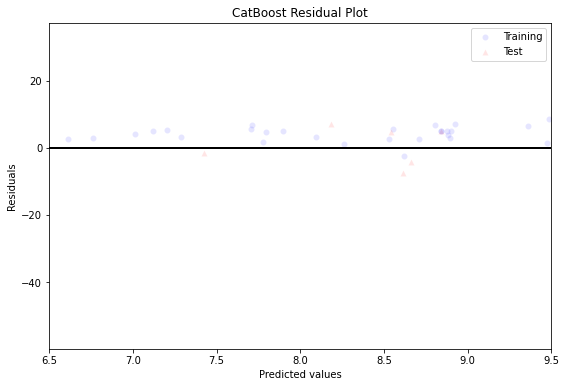

In [ ]:
train_preds = cb_reg.predict(X_train)

residual_plot(y_train[:10000], train_preds[:10000], 
              y_val[:10000], val_preds[:10000], 
              title="CatBoost Residual Plot")

In [ ]:
feat_importances = cb_reg.get_feature_importance(prettified=True)
feat_importances

,Feature Id,Importances
0,len_of_content,5.761227
1,price,5.286588
2,pca_10,4.628413
3,pca_6,4.357469
4,pca_2,3.979073
...,...,...
891,x1_حي ظهرة البديعة,0.000000
892,x1_حي عتيقة,0.000000
893,x1_حي غبيرة,0.000000
894,x1_حي منفوحة,0.000000


Text(0.5, 1.0, 'CatBoost features importance:')

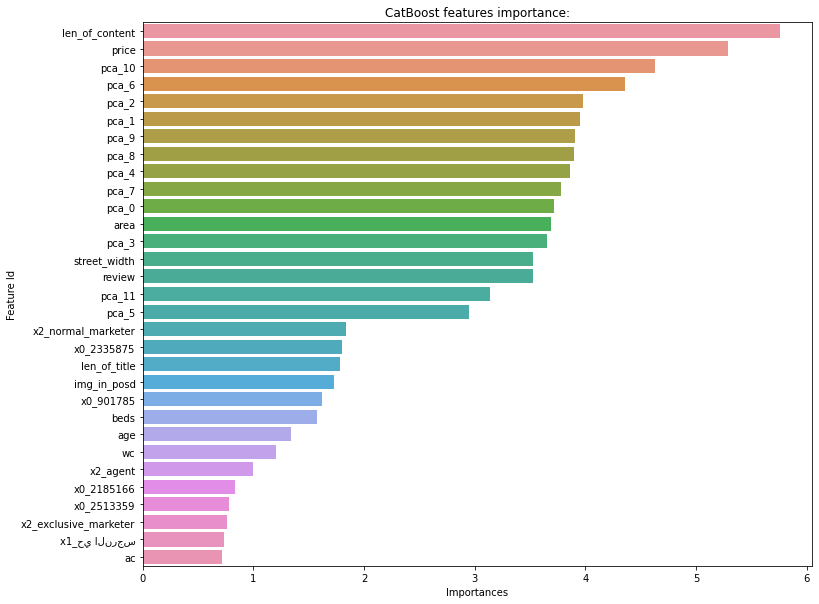

In [ ]:
plt.figure(figsize=(12, 10))
sns.barplot(x="Importances", y="Feature Id", data=feat_importances.loc[:30, :])
plt.title('CatBoost features importance:')

In [ ]:
train_data = Pool(data=X_train, label=y_train)

val_data = Pool(data=X_val, label=y_val)

In [ ]:
explainer = shap.TreeExplainer(cb_reg_1) 
shap_values = explainer.shap_values(train_data)

# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[:100,:], X_train.iloc[:100,:])

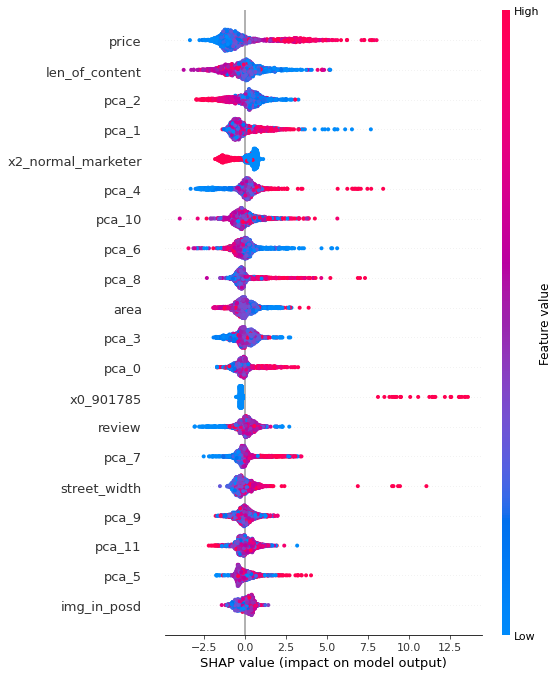

In [ ]:
shap.summary_plot(shap_values, X_train)

In [46]:
N_FOLDS =5
k_folds = KFold(n_splits=N_FOLDS, shuffle=True)

# convert y values into appropriate form
y_array = y.values.reshape(-1, 1)

In [47]:
model_rmses = []
test_preds = np.zeros((X_test.shape[0], 1))

for train_idx, val_idx in tqdm(k_folds.split(X, y)):
    train_split = X.iloc[train_idx].copy()
    train_labels = y.iloc[train_idx].astype(np.float64).copy()
    val_split = X.iloc[val_idx].copy()
    val_labels = y.iloc[val_idx].astype(np.float64).copy()
    
    temp_model = CatBoostRegressor()
    
    # train model for 100 epochs with early stopping
    temp_model.fit(train_split, train_labels, 
               eval_set=(val_split, val_labels), 
               use_best_model=True,
               early_stopping_rounds=early_stop_rounds)
    
    # find log loss for out of fold val data
    model_val_preds = temp_model.predict(val_split)
    
    # calculate mean squared error on val sub-set preds
    fold_rmse = np.sqrt(mean_squared_error(model_val_preds, val_labels))
    model_rmses.append(fold_rmse)
    print(f'Current Fold validation RMSE: {fold_rmse:.4f}')
    
    # make predictions on test set for each fold
    temp_test_preds = temp_model.predict(X_test).reshape(-1, 1)
    test_preds += (temp_test_preds / N_FOLDS)

# convert results to np array
model_rmses = np.array(model_rmses)


0it [00:00, ?it/s]


NameError: name 'early_stop_rounds' is not defined

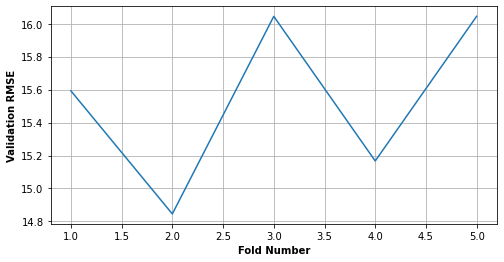

In [ ]:
plt.figure(figsize=(8,4))
sns.lineplot(x=range(1, model_rmses.shape[0]+1), y=model_rmses)
plt.xlabel("Fold Number", weight='bold')
plt.ylabel("Validation RMSE", weight='bold')
plt.grid()
plt.show()

---------


In [48]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

2022-08-23 10:30:08.145176: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vscode/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-08-23 10:30:08.145205: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# LGBMRegressor

In [49]:
from lightgbm import LGBMRegressor

lgbmRegressor = LGBMRegressor()
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("lgbmRegressor", lgbmRegressor),
])
model_pipeline.fit(X_train, y_train)
results = cross_val_score(model_pipeline, X_test, y_test.values.ravel(), cv=k, scoring=loss)

np.abs(np.mean(results))

17.091857405953608


# XGBRegressor

In [50]:
from xgboost import XGBRegressor

In [51]:

kf = KFold(n_splits=5, shuffle=True, random_state=0)

# defining model
xgbreg = XGBRegressor()
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("xgbreg", xgbreg),
])
# taking positive because cross val score returns -ve values
results = cross_val_score(model_pipeline, X_test, y_test.values.ravel(), cv=k, scoring=loss)

np.abs(np.mean(results))
# printing the output
# print(f"Scores - {scores}\nMean - {sum(scores)/len(scores)}")

16.513401562489552

In [52]:
# print(f"Scores - {results}\nMean - {sum(results)/len(results)}")

In [53]:
def Objective(trial):
    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [150, 200, 250, 300]),
        "eta": trial.suggest_loguniform("eta",1e-2,0.1),
        "subsample": trial.suggest_discrete_uniform("subsample", 0.6,1,0.1),
        "min_child_weight": trial.suggest_int("min_child_weight",5,11),
        "colsample_bytree": trial.suggest_discrete_uniform("colsample_bytree", 0.6,1,0.1),
        "max_depth": trial.suggest_categorical("max_depth",[5,7,9,11,13]),
        "random_state": 2021
    }
    
    model = XGBRegressor(**params)
    
    model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
     ("model", model),
    ])
    # taking positive because cross val score returns -ve values
    
    results = cross_val_score(model_pipeline, X_test, y_test.values.ravel(), cv=k, scoring=loss)

    
    
    return np.abs(np.mean(results))

In [54]:
import optuna

In [55]:
study = optuna.create_study(direction="minimize", study_name='Xgboost optimization')
study.optimize(Objective, n_trials=10)

[I 2022-08-23 10:30:39,986] A new study created in memory with name: Xgboost optimization
[I 2022-08-23 10:30:44,942] Trial 0 finished with value: 16.56961579391857 and parameters: {'n_estimators': 200, 'eta': 0.015134451361365616, 'subsample': 0.6, 'min_child_weight': 6, 'colsample_bytree': 0.7, 'max_depth': 7}. Best is trial 0 with value: 16.56961579391857.
[I 2022-08-23 10:30:49,038] Trial 1 finished with value: 17.233435905982827 and parameters: {'n_estimators': 200, 'eta': 0.0833531931151819, 'subsample': 0.7, 'min_child_weight': 7, 'colsample_bytree': 0.7, 'max_depth': 13}. Best is trial 0 with value: 16.56961579391857.
[I 2022-08-23 10:30:56,074] Trial 2 finished with value: 16.68601027324142 and parameters: {'n_estimators': 250, 'eta': 0.013113901339836115, 'subsample': 0.6, 'min_child_weight': 8, 'colsample_bytree': 0.7, 'max_depth': 13}. Best is trial 0 with value: 16.56961579391857.
[I 2022-08-23 10:31:05,899] Trial 3 finished with value: 17.060243886412998 and parameters: {

In [56]:
XGB_params = study.best_params

study.best_params

{'n_estimators': 200,
 'eta': 0.015134451361365616,
 'subsample': 0.6,
 'min_child_weight': 6,
 'colsample_bytree': 0.7,
 'max_depth': 7}

# LightGBM

In [57]:
import lightgbm as lgbm


In [58]:
lgbreg = lgbm.LGBMRegressor()
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("lgbreg", lgbreg),
])
# taking positive because cross val score returns -ve values
results = cross_val_score(model_pipeline, X_test, y_test.values.ravel(), cv=k, scoring=loss)

np.abs(np.mean(results))

17.091857405953608

In [59]:
def Objective(trial):
    params = {
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    model = lgbm.LGBMRegressor(**params)
    model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("model", model),
])
    
    # taking positive because cross val score returns -ve values
    results = cross_val_score(model_pipeline, X_test, y_test.values.ravel(), cv=k, scoring=loss)


    
    return np.abs(np.mean(results))

In [60]:
study = optuna.create_study(direction="minimize", study_name='LGBM optimization')
study.optimize(Objective, n_trials=20)

[I 2022-08-23 10:31:34,050] A new study created in memory with name: LGBM optimization


[LightGBM] [Warning] lambda_l1 is set=0.0001533345692667945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001533345692667945
[LightGBM] [Warning] feature_fraction is set=0.8228154756354996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8228154756354996
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=4.153891422128507e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.153891422128507e-05
[LightGBM] [Warning] bagging_fraction is set=0.6111751096221316, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6111751096221316
[LightGBM] [Warning] lambda_l1 is set=0.0001533345692667945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001533345692667945
[LightGBM] [Warning] feature_fraction is set=0.8228154756354996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8228154756354996
[LightGBM] [Warning

[I 2022-08-23 10:31:34,446] Trial 0 finished with value: 17.378656397564075 and parameters: {'lambda_l1': 0.0001533345692667945, 'lambda_l2': 4.153891422128507e-05, 'num_leaves': 71, 'feature_fraction': 0.8228154756354996, 'bagging_fraction': 0.6111751096221316, 'bagging_freq': 2, 'min_child_samples': 6}. Best is trial 0 with value: 17.378656397564075.


[LightGBM] [Warning] lambda_l1 is set=0.0001533345692667945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001533345692667945
[LightGBM] [Warning] feature_fraction is set=0.8228154756354996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8228154756354996
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=4.153891422128507e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.153891422128507e-05
[LightGBM] [Warning] bagging_fraction is set=0.6111751096221316, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6111751096221316
[LightGBM] [Warning] lambda_l1 is set=0.0001533345692667945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001533345692667945
[LightGBM] [Warning] feature_fraction is set=0.8228154756354996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8228154756354996
[LightGBM] [Warning

[I 2022-08-23 10:31:34,644] Trial 1 finished with value: 16.846840452171048 and parameters: {'lambda_l1': 0.9048345890878137, 'lambda_l2': 0.15804916396095148, 'num_leaves': 162, 'feature_fraction': 0.7568739216243502, 'bagging_fraction': 0.9098017762263759, 'bagging_freq': 4, 'min_child_samples': 91}. Best is trial 1 with value: 16.846840452171048.


[LightGBM] [Warning] lambda_l1 is set=0.9048345890878137, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9048345890878137
[LightGBM] [Warning] feature_fraction is set=0.7568739216243502, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7568739216243502
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.15804916396095148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15804916396095148
[LightGBM] [Warning] bagging_fraction is set=0.9098017762263759, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9098017762263759
[LightGBM] [Warning] lambda_l1 is set=0.9048345890878137, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9048345890878137
[LightGBM] [Warning] feature_fraction is set=0.7568739216243502, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7568739216243502
[LightGBM] [Warning] bagging_freq i

[I 2022-08-23 10:31:34,835] Trial 2 finished with value: 16.903066204463098 and parameters: {'lambda_l1': 0.0025752901372793867, 'lambda_l2': 2.6369462738747385, 'num_leaves': 216, 'feature_fraction': 0.5592391660940774, 'bagging_fraction': 0.5522572536050646, 'bagging_freq': 5, 'min_child_samples': 98}. Best is trial 1 with value: 16.846840452171048.


[LightGBM] [Warning] lambda_l1 is set=0.0025752901372793867, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0025752901372793867
[LightGBM] [Warning] feature_fraction is set=0.5592391660940774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5592391660940774
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=2.6369462738747385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6369462738747385
[LightGBM] [Warning] bagging_fraction is set=0.5522572536050646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5522572536050646
[LightGBM] [Warning] lambda_l1 is set=0.0025752901372793867, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0025752901372793867
[LightGBM] [Warning] feature_fraction is set=0.5592391660940774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5592391660940774
[LightGBM] [Warning] bagg

[I 2022-08-23 10:31:35,045] Trial 3 finished with value: 17.02894229319002 and parameters: {'lambda_l1': 2.572880003727923e-08, 'lambda_l2': 0.03280600890644048, 'num_leaves': 219, 'feature_fraction': 0.8004036261141116, 'bagging_fraction': 0.5177735781962857, 'bagging_freq': 4, 'min_child_samples': 97}. Best is trial 1 with value: 16.846840452171048.


[LightGBM] [Warning] lambda_l1 is set=2.572880003727923e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.572880003727923e-08
[LightGBM] [Warning] feature_fraction is set=0.8004036261141116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8004036261141116
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.03280600890644048, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03280600890644048
[LightGBM] [Warning] bagging_fraction is set=0.5177735781962857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5177735781962857
[LightGBM] [Warning] lambda_l1 is set=2.572880003727923e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.572880003727923e-08
[LightGBM] [Warning] feature_fraction is set=0.8004036261141116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8004036261141116
[LightGBM] [Warning] ba

[I 2022-08-23 10:31:35,292] Trial 4 finished with value: 17.488943517862616 and parameters: {'lambda_l1': 1.918412429564256e-08, 'lambda_l2': 0.006886552378797598, 'num_leaves': 111, 'feature_fraction': 0.9344926518831955, 'bagging_fraction': 0.8091393406546417, 'bagging_freq': 1, 'min_child_samples': 43}. Best is trial 1 with value: 16.846840452171048.


[LightGBM] [Warning] lambda_l1 is set=1.918412429564256e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.918412429564256e-08
[LightGBM] [Warning] feature_fraction is set=0.9344926518831955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9344926518831955
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.006886552378797598, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006886552378797598
[LightGBM] [Warning] bagging_fraction is set=0.8091393406546417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8091393406546417
[LightGBM] [Warning] lambda_l1 is set=1.918412429564256e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.918412429564256e-08
[LightGBM] [Warning] feature_fraction is set=0.9344926518831955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9344926518831955
[LightGBM] [Warning] 

[I 2022-08-23 10:31:35,520] Trial 5 finished with value: 17.44840047840991 and parameters: {'lambda_l1': 0.04267053691048911, 'lambda_l2': 0.0006891844200939102, 'num_leaves': 207, 'feature_fraction': 0.9331189892497538, 'bagging_fraction': 0.8600202255934808, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 1 with value: 16.846840452171048.


[LightGBM] [Warning] lambda_l1 is set=0.04267053691048911, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04267053691048911
[LightGBM] [Warning] feature_fraction is set=0.9331189892497538, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9331189892497538
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0006891844200939102, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006891844200939102
[LightGBM] [Warning] bagging_fraction is set=0.8600202255934808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8600202255934808
[LightGBM] [Warning] lambda_l1 is set=0.04267053691048911, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04267053691048911
[LightGBM] [Warning] feature_fraction is set=0.9331189892497538, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9331189892497538
[LightGBM] [Warning] baggin

[I 2022-08-23 10:31:35,707] Trial 6 finished with value: 16.812397574625237 and parameters: {'lambda_l1': 1.3257701269879607, 'lambda_l2': 0.0004334972429669665, 'num_leaves': 17, 'feature_fraction': 0.6815167108914421, 'bagging_fraction': 0.8249865779479817, 'bagging_freq': 6, 'min_child_samples': 99}. Best is trial 6 with value: 16.812397574625237.


[LightGBM] [Warning] lambda_l1 is set=1.3257701269879607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3257701269879607
[LightGBM] [Warning] feature_fraction is set=0.6815167108914421, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6815167108914421
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0004334972429669665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004334972429669665
[LightGBM] [Warning] bagging_fraction is set=0.8249865779479817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8249865779479817
[LightGBM] [Warning] lambda_l1 is set=0.9706906449955532, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9706906449955532
[LightGBM] [Warning] feature_fraction is set=0.6722424434835528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6722424434835528
[LightGBM] [Warning] bagging_fr

[I 2022-08-23 10:31:35,974] Trial 7 finished with value: 17.215537095262526 and parameters: {'lambda_l1': 0.9706906449955532, 'lambda_l2': 4.32825533533793, 'num_leaves': 131, 'feature_fraction': 0.6722424434835528, 'bagging_fraction': 0.7534736496440799, 'bagging_freq': 4, 'min_child_samples': 15}. Best is trial 6 with value: 16.812397574625237.


[LightGBM] [Warning] lambda_l1 is set=0.9706906449955532, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9706906449955532
[LightGBM] [Warning] feature_fraction is set=0.6722424434835528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6722424434835528
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=4.32825533533793, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.32825533533793
[LightGBM] [Warning] bagging_fraction is set=0.7534736496440799, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7534736496440799
[LightGBM] [Warning] lambda_l1 is set=0.0013200545912799757, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013200545912799757
[LightGBM] [Warning] feature_fraction is set=0.6467866950820856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6467866950820856
[LightGBM] [Warning] bagging_freq i

[I 2022-08-23 10:31:36,195] Trial 8 finished with value: 16.981212160808223 and parameters: {'lambda_l1': 0.0013200545912799757, 'lambda_l2': 9.721555541064304e-05, 'num_leaves': 85, 'feature_fraction': 0.6467866950820856, 'bagging_fraction': 0.9681870953714707, 'bagging_freq': 6, 'min_child_samples': 69}. Best is trial 6 with value: 16.812397574625237.


[LightGBM] [Warning] lambda_l1 is set=0.0013200545912799757, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013200545912799757
[LightGBM] [Warning] feature_fraction is set=0.6467866950820856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6467866950820856
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.721555541064304e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.721555541064304e-05
[LightGBM] [Warning] bagging_fraction is set=0.9681870953714707, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9681870953714707
[LightGBM] [Warning] lambda_l1 is set=0.0005760053323136672, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005760053323136672
[LightGBM] [Warning] feature_fraction is set=0.8557290182443107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8557290182443107
[LightGBM] [Warning

[I 2022-08-23 10:31:36,445] Trial 9 finished with value: 17.455243382301372 and parameters: {'lambda_l1': 0.0005760053323136672, 'lambda_l2': 1.92857563267037, 'num_leaves': 84, 'feature_fraction': 0.8557290182443107, 'bagging_fraction': 0.7893213715499403, 'bagging_freq': 3, 'min_child_samples': 24}. Best is trial 6 with value: 16.812397574625237.


[LightGBM] [Warning] lambda_l1 is set=0.0005760053323136672, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005760053323136672
[LightGBM] [Warning] feature_fraction is set=0.8557290182443107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8557290182443107
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.92857563267037, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.92857563267037
[LightGBM] [Warning] bagging_fraction is set=0.7893213715499403, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7893213715499403
[LightGBM] [Warning] lambda_l1 is set=3.4644243492193163e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4644243492193163e-06
[LightGBM] [Warning] feature_fraction is set=0.49101022466974514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49101022466974514
[LightGBM] [Warning] bagg

[I 2022-08-23 10:31:36,662] Trial 10 finished with value: 17.048341410472332 and parameters: {'lambda_l1': 3.4644243492193163e-06, 'lambda_l2': 6.20450693621912e-08, 'num_leaves': 3, 'feature_fraction': 0.49101022466974514, 'bagging_fraction': 0.6626353431345907, 'bagging_freq': 7, 'min_child_samples': 68}. Best is trial 6 with value: 16.812397574625237.


[LightGBM] [Warning] lambda_l1 is set=3.4644243492193163e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4644243492193163e-06
[LightGBM] [Warning] feature_fraction is set=0.49101022466974514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49101022466974514
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=6.20450693621912e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.20450693621912e-08
[LightGBM] [Warning] bagging_fraction is set=0.6626353431345907, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6626353431345907
[LightGBM] [Warning] lambda_l1 is set=4.122300569751729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.122300569751729
[LightGBM] [Warning] feature_fraction is set=0.7294117953043119, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7294117953043119
[LightGBM] [Warning] bagg

[I 2022-08-23 10:31:36,863] Trial 11 finished with value: 16.91035931579857 and parameters: {'lambda_l1': 4.122300569751729, 'lambda_l2': 1.3027213712945228e-06, 'num_leaves': 162, 'feature_fraction': 0.7294117953043119, 'bagging_fraction': 0.9522491857112411, 'bagging_freq': 7, 'min_child_samples': 81}. Best is trial 6 with value: 16.812397574625237.
[I 2022-08-23 10:31:37,064] Trial 12 finished with value: 16.90535157001295 and parameters: {'lambda_l1': 0.10004275431070574, 'lambda_l2': 0.06323439539261952, 'num_leaves': 19, 'feature_fraction': 0.5699527422366405, 'bagging_fraction': 0.8751065666465517, 'bagging_freq': 5, 'min_child_samples': 81}. Best is trial 6 with value: 16.812397574625237.


[LightGBM] [Warning] lambda_l1 is set=0.10004275431070574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10004275431070574
[LightGBM] [Warning] feature_fraction is set=0.5699527422366405, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5699527422366405
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.06323439539261952, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06323439539261952
[LightGBM] [Warning] bagging_fraction is set=0.8751065666465517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8751065666465517
[LightGBM] [Warning] lambda_l1 is set=0.10004275431070574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10004275431070574
[LightGBM] [Warning] feature_fraction is set=0.5699527422366405, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5699527422366405
[LightGBM] [Warning] bagging_fr

[I 2022-08-23 10:31:37,263] Trial 13 finished with value: 16.963844771453434 and parameters: {'lambda_l1': 0.1178499880692442, 'lambda_l2': 5.986702066796353e-06, 'num_leaves': 171, 'feature_fraction': 0.7366508969494625, 'bagging_fraction': 0.9060759398823122, 'bagging_freq': 5, 'min_child_samples': 84}. Best is trial 6 with value: 16.812397574625237.


[LightGBM] [Warning] lambda_l1 is set=0.1178499880692442, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1178499880692442
[LightGBM] [Warning] feature_fraction is set=0.7366508969494625, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7366508969494625
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=5.986702066796353e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.986702066796353e-06
[LightGBM] [Warning] bagging_fraction is set=0.9060759398823122, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9060759398823122
[LightGBM] [Warning] lambda_l1 is set=0.1178499880692442, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1178499880692442
[LightGBM] [Warning] feature_fraction is set=0.7366508969494625, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7366508969494625
[LightGBM] [Warning] bagging_fr

[I 2022-08-23 10:31:37,470] Trial 14 finished with value: 17.15123148286256 and parameters: {'lambda_l1': 9.26541743044213, 'lambda_l2': 0.0017738485326070932, 'num_leaves': 36, 'feature_fraction': 0.40199982061420875, 'bagging_fraction': 0.7006406948874, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 6 with value: 16.812397574625237.


[LightGBM] [Warning] lambda_l1 is set=9.26541743044213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.26541743044213
[LightGBM] [Warning] feature_fraction is set=0.40199982061420875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40199982061420875
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0017738485326070932, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017738485326070932
[LightGBM] [Warning] bagging_fraction is set=0.7006406948874, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7006406948874
[LightGBM] [Warning] lambda_l1 is set=9.26541743044213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.26541743044213
[LightGBM] [Warning] feature_fraction is set=0.40199982061420875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40199982061420875
[LightGBM] [Warning] bagging_freq is set=

[I 2022-08-23 10:31:37,679] Trial 15 finished with value: 16.897016585192 and parameters: {'lambda_l1': 0.3607638605178717, 'lambda_l2': 0.10671546883011204, 'num_leaves': 156, 'feature_fraction': 0.5978315214467356, 'bagging_fraction': 0.9805060400077086, 'bagging_freq': 3, 'min_child_samples': 99}. Best is trial 6 with value: 16.812397574625237.


[LightGBM] [Warning] lambda_l1 is set=0.3607638605178717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3607638605178717
[LightGBM] [Warning] feature_fraction is set=0.5978315214467356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5978315214467356
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.10671546883011204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10671546883011204
[LightGBM] [Warning] bagging_fraction is set=0.9805060400077086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9805060400077086
[LightGBM] [Warning] lambda_l1 is set=0.3607638605178717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3607638605178717
[LightGBM] [Warning] feature_fraction is set=0.5978315214467356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5978315214467356
[LightGBM] [Warning] bagging_freq i

[I 2022-08-23 10:31:37,883] Trial 16 finished with value: 16.832011373564747 and parameters: {'lambda_l1': 1.8270374484176544e-05, 'lambda_l2': 1.9876466171767285e-08, 'num_leaves': 51, 'feature_fraction': 0.7585035529194069, 'bagging_fraction': 0.8226157874466227, 'bagging_freq': 6, 'min_child_samples': 88}. Best is trial 6 with value: 16.812397574625237.


[LightGBM] [Warning] lambda_l1 is set=1.8270374484176544e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8270374484176544e-05
[LightGBM] [Warning] feature_fraction is set=0.7585035529194069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7585035529194069
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.9876466171767285e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9876466171767285e-08
[LightGBM] [Warning] bagging_fraction is set=0.8226157874466227, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8226157874466227
[LightGBM] [Warning] lambda_l1 is set=1.8270374484176544e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8270374484176544e-05
[LightGBM] [Warning] feature_fraction is set=0.7585035529194069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7585035529194069
[LightGBM] [W

[I 2022-08-23 10:31:38,094] Trial 17 finished with value: 16.935446427730916 and parameters: {'lambda_l1': 1.0004782203257914e-05, 'lambda_l2': 1.1108295829043083e-07, 'num_leaves': 35, 'feature_fraction': 0.8631781027821281, 'bagging_fraction': 0.4566517927736803, 'bagging_freq': 6, 'min_child_samples': 66}. Best is trial 6 with value: 16.812397574625237.


[LightGBM] [Warning] lambda_l1 is set=1.0004782203257914e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0004782203257914e-05
[LightGBM] [Warning] feature_fraction is set=0.8631781027821281, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8631781027821281
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.1108295829043083e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1108295829043083e-07
[LightGBM] [Warning] bagging_fraction is set=0.4566517927736803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4566517927736803
[LightGBM] [Warning] lambda_l1 is set=1.0004782203257914e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0004782203257914e-05
[LightGBM] [Warning] feature_fraction is set=0.8631781027821281, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8631781027821281
[LightGBM] [W

[I 2022-08-23 10:31:38,295] Trial 18 finished with value: 17.172327553574526 and parameters: {'lambda_l1': 9.112952132959894e-07, 'lambda_l2': 1.3166822274618727e-06, 'num_leaves': 55, 'feature_fraction': 0.6516142477204616, 'bagging_fraction': 0.7417420998982669, 'bagging_freq': 7, 'min_child_samples': 55}. Best is trial 6 with value: 16.812397574625237.


[LightGBM] [Warning] lambda_l1 is set=9.112952132959894e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.112952132959894e-07
[LightGBM] [Warning] feature_fraction is set=0.6516142477204616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6516142477204616
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.3166822274618727e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3166822274618727e-06
[LightGBM] [Warning] bagging_fraction is set=0.7417420998982669, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7417420998982669
[LightGBM] [Warning] lambda_l1 is set=9.112952132959894e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.112952132959894e-07
[LightGBM] [Warning] feature_fraction is set=0.6516142477204616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6516142477204616
[LightGBM] [Warni

[I 2022-08-23 10:31:38,485] Trial 19 finished with value: 16.924024019699043 and parameters: {'lambda_l1': 7.199829027248884e-05, 'lambda_l2': 1.787491640575837e-08, 'num_leaves': 2, 'feature_fraction': 0.7727451047507727, 'bagging_fraction': 0.8245958637767578, 'bagging_freq': 6, 'min_child_samples': 87}. Best is trial 6 with value: 16.812397574625237.


[LightGBM] [Warning] lambda_l1 is set=7.199829027248884e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.199829027248884e-05
[LightGBM] [Warning] feature_fraction is set=0.7727451047507727, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7727451047507727
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.787491640575837e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.787491640575837e-08
[LightGBM] [Warning] bagging_fraction is set=0.8245958637767578, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8245958637767578
[LightGBM] [Warning] lambda_l1 is set=7.199829027248884e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.199829027248884e-05
[LightGBM] [Warning] feature_fraction is set=0.7727451047507727, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7727451047507727
[LightGBM] [Warning

In [61]:
lgb_params = study.best_params
study.best_params

{'lambda_l1': 1.3257701269879607,
 'lambda_l2': 0.0004334972429669665,
 'num_leaves': 17,
 'feature_fraction': 0.6815167108914421,
 'bagging_fraction': 0.8249865779479817,
 'bagging_freq': 6,
 'min_child_samples': 99}

-------

In [62]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
final_estimator =  CatBoostRegressor( random_seed=13, verbose=200)

estimators = [('xgb', XGBRegressor( )),
        #       ('lgb', lgbm.LGBMRegressor(**lgb_params))
                  ("reg", reg),
                ("lgbreg", lgbreg),
              ]
# model_pipeline = Pipeline(steps=[
# ("preprocessor", preprocessor),
# ("final_estimator", final_estimator),
# ])
reg = StackingRegressor(
        estimators=estimators,
         final_estimator=final_estimator)
model_pipeline = Pipeline(steps=[
("preprocessor", preprocessor),
("reg", reg),
])
cb_reg_1 = model_pipeline.fit(X_train , y_train)

Learning rate set to 0.046011
0:	learn: 17.5925647	total: 811us	remaining: 811ms
200:	learn: 14.2665737	total: 122ms	remaining: 487ms
400:	learn: 13.3098686	total: 247ms	remaining: 369ms
600:	learn: 12.4542405	total: 371ms	remaining: 246ms
800:	learn: 11.7402266	total: 512ms	remaining: 127ms
999:	learn: 11.1160916	total: 637ms	remaining: 0us


In [63]:
results = cross_val_score(cb_reg_1, X_test, y_test.values.ravel(), cv=k, scoring=loss)

np.abs(np.mean(results))

Learning rate set to 0.035685
0:	learn: 17.1315881	total: 412us	remaining: 412ms
200:	learn: 13.4267074	total: 77.1ms	remaining: 307ms
400:	learn: 11.4360191	total: 159ms	remaining: 237ms
600:	learn: 9.6458498	total: 266ms	remaining: 177ms
800:	learn: 8.2871235	total: 346ms	remaining: 86.1ms
999:	learn: 7.2529887	total: 429ms	remaining: 0us
Learning rate set to 0.035685
0:	learn: 16.6979301	total: 761us	remaining: 761ms
200:	learn: 12.5068066	total: 84.4ms	remaining: 335ms
400:	learn: 10.6013566	total: 165ms	remaining: 246ms
600:	learn: 8.9275051	total: 257ms	remaining: 170ms
800:	learn: 7.8176042	total: 341ms	remaining: 84.6ms
999:	learn: 6.8391432	total: 425ms	remaining: 0us
Learning rate set to 0.035685
0:	learn: 16.7015167	total: 548us	remaining: 548ms
200:	learn: 12.6508954	total: 81.1ms	remaining: 322ms
400:	learn: 10.6091807	total: 171ms	remaining: 256ms
600:	learn: 9.0240124	total: 266ms	remaining: 177ms
800:	learn: 7.7352851	total: 348ms	remaining: 86.5ms
999:	learn: 6.6816926

17.85061553373459

In [65]:
import joblib
joblib.dump(cb_reg_1, "reg.pkl")

['reg.pkl']